# California Housing Price Prediction
#### Practise of Elements Learned in Chapter 1 of "Hands-On Machine Learning With Scikit-Learn,  Keras & TensorFlow"
#### Notebook By : Akash Agnihotri

In [94]:
# Import Data
import pandas as pd
import numpy as np
from scipy import stats
import urllib
import os

import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
%matplotlib inline

## Part 1 : Loading and Evaluating Data

In [2]:
# Fetch data from book's github repository and dump into disk, and load it into dataframe
data_url = 'https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.csv'
data_file_path = os.path.join('datasets','housing')
def fetch_housing_data(data_url=data_url,data_file_path=data_file_path):
    os.makedirs(data_file_path,exist_ok=True)
    csv_file_path = os.path.join(data_file_path,'housing.csv')
    urllib.request.urlretrieve(data_url,csv_file_path)
    df = pd.read_csv(csv_file_path)
    return df

In [3]:
# Load Data And Sample it
df = fetch_housing_data()
print(f'Shape of is {df.shape[0]} rows and {df.shape[1]} columns')
df.sample(5)

Shape of is 20640 rows and 10 columns


In [5]:
# Check the data count and data type for all the available columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [6]:
# Check  the distribution of categorical variable
df['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [7]:
# Check the distribution of continues variables
df.drop(['ocean_proximity'],axis=1).describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


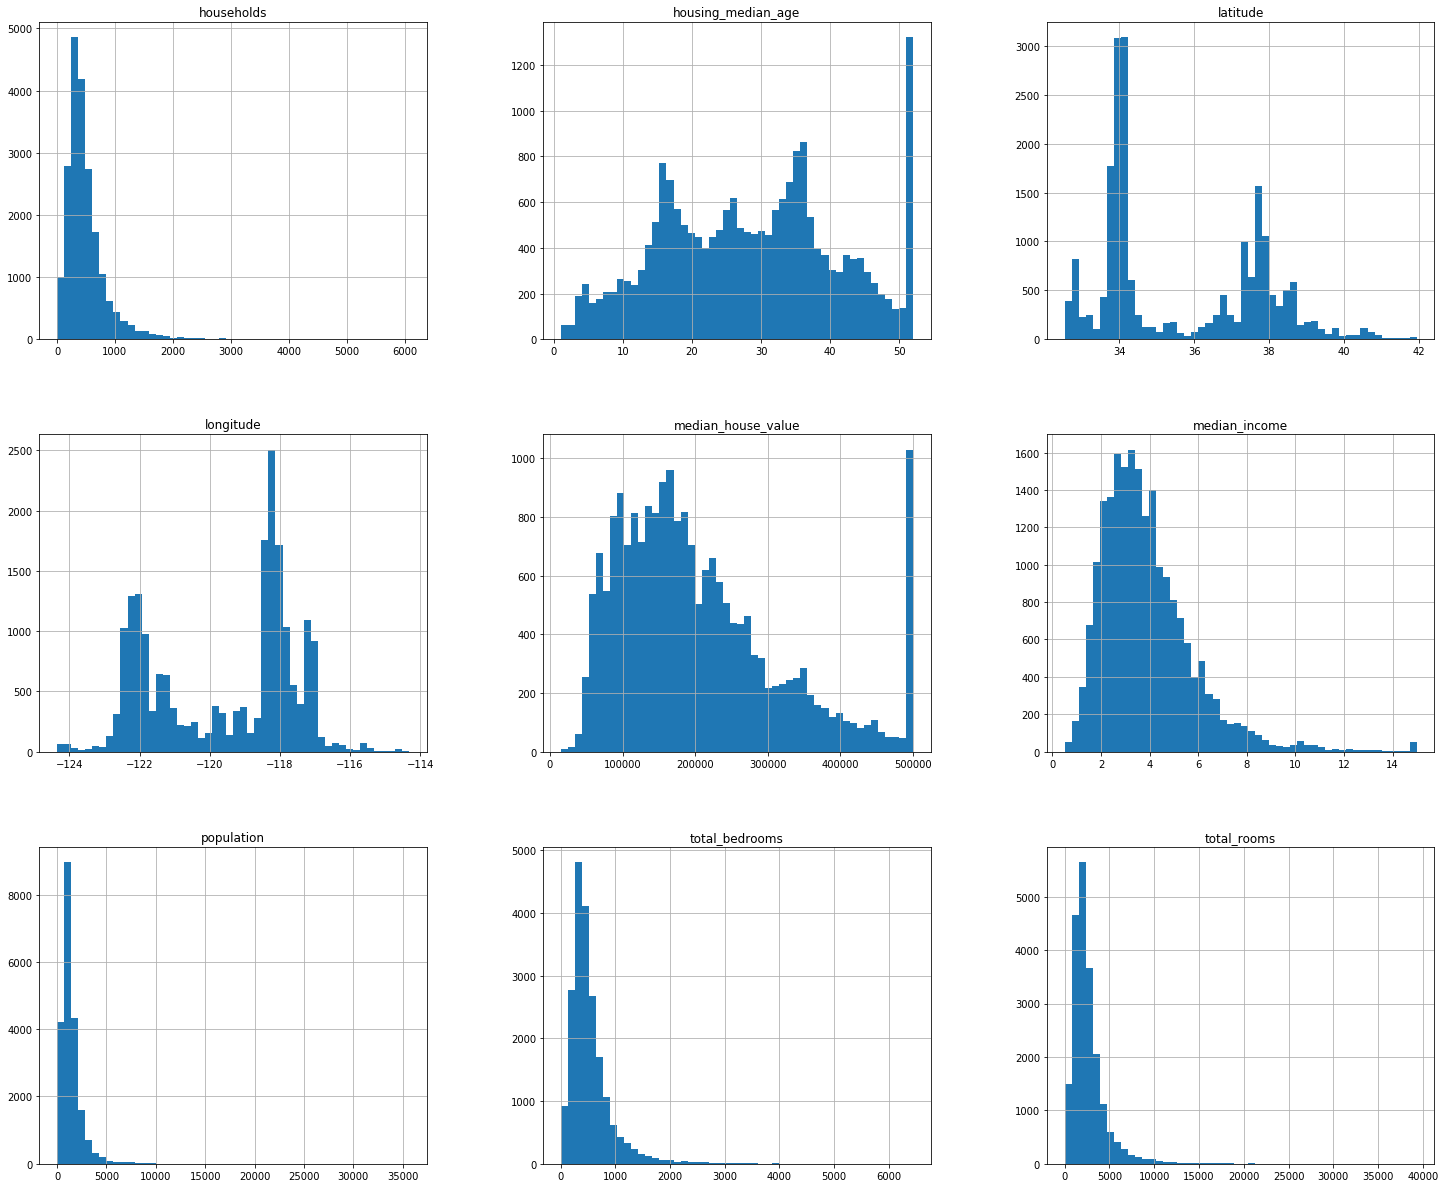

In [8]:
# Plot the histogram of all the continues variables
hist_plot = df.drop(['ocean_proximity'],axis=1).hist(bins=50,figsize=(25,21))

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: median_income_cut, dtype: float64

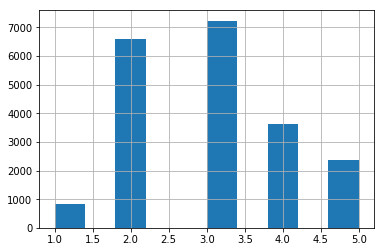

In [10]:
# Bin the Median Income variable to so that we can split  data without creating sampling bias
df['median_income_cut'] = pd.cut(df['median_income'],bins=[0,1.5,3,4.5,6,np.inf],labels=[1,2,3,4,5])
hist_plot = df['median_income_cut'].hist()
df['median_income_cut'].value_counts()/len(df)

In [11]:
# Stratified Sampling is done, so that both train & test samples will have similar distribution of important variables
split = StratifiedShuffleSplit(n_splits=10,test_size=0.2,random_state=42)
train = test = 0
for train_loc,test_loc in split.split(df,df['median_income_cut']):
    train = df.loc[train_loc]
    test = df.loc[test_loc]

In [12]:
# Check if the distribution is similar to full dataset after spliting
cut_check = pd.DataFrame([df['median_income_cut'].value_counts()/len(df),train['median_income_cut'].value_counts()/len(train),
                          test['median_income_cut'].value_counts()/len(test)]).T
cut_check.columns = ['Overall','Training Set','Test Set']
cut_check.sort_index()

,Overall,Training Set,Test Set
1,0.039826,0.039850,0.039729
2,0.318847,0.318859,0.318798
3,0.350581,0.350594,0.350533
4,0.176308,0.176296,0.176357
5,0.114438,0.114402,0.114583


In [13]:
# Drop the binned column we created and dump the data from train & test set into files
train = train.drop(['median_income_cut'],axis=1)
test = test.drop(['median_income_cut'],axis=1)
train.to_csv(os.path.join(data_file_path,'train.csv'),index=False)
test.to_csv(os.path.join(data_file_path,'test.csv'),index=False)

In [14]:
# Create a copy training data set for further analysis
df = train.copy()

## Part 2 : Exploratory Data Analysis & Feature Engineering

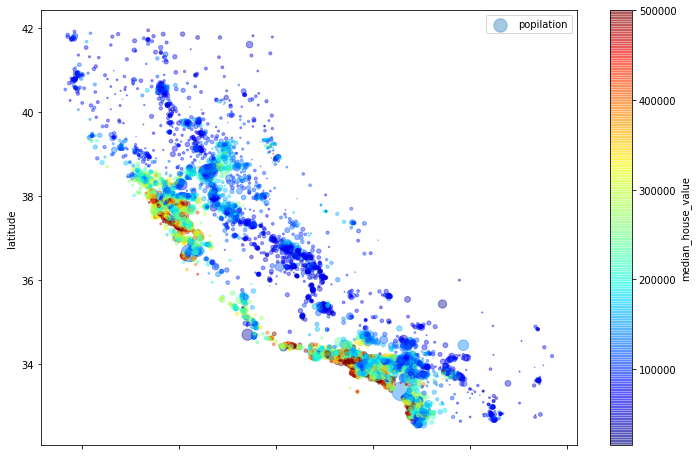

In [15]:
# Plot the Latitude & Longitude to visualize the distribution of population and median house value
sct_plot = df.plot(kind='scatter',x='longitude',y='latitude',alpha=0.4,s=df['population']/100,
                   label='popilation',c='median_house_value',cmap=plt.get_cmap('jet'),figsize=(12,8),colorbar=True)
sct_plot = plt.legend()

In [16]:
# Calculate the correlation of numerical variables with target variable 'median house price'
scat_mat = df.drop(['ocean_proximity'],axis=1).corr()
scat_mat['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687691
total_rooms           0.133371
housing_median_age    0.108680
households            0.064481
total_bedrooms        0.047338
population           -0.026199
longitude            -0.046952
latitude             -0.144846
Name: median_house_value, dtype: float64

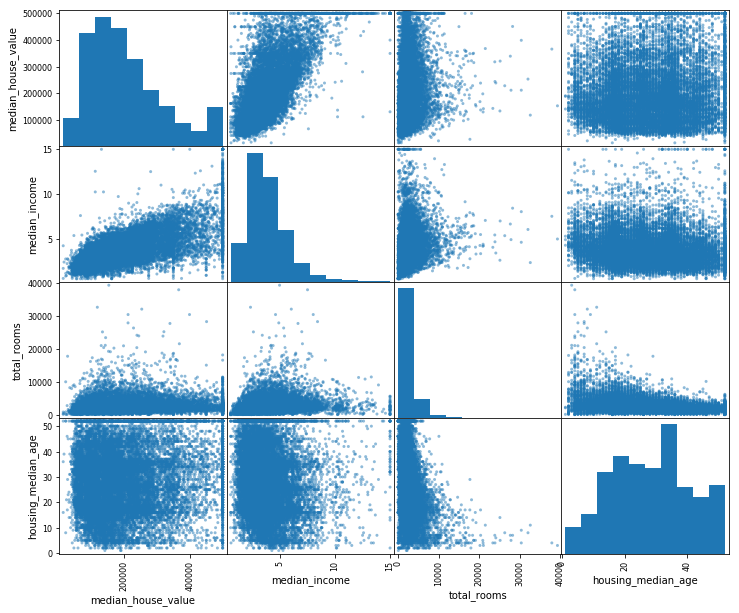

In [17]:
# Plot scater plot matrix to visualize the correlation of variabes with each other
scat_plot = pd.plotting.scatter_matrix(df[['median_house_value','median_income','total_rooms',
                                           'housing_median_age']],figsize=(12,10))

In [18]:
# Build 3 new variables as per our intution and business understanding
df['rooms_per_household'] = df['total_rooms']/df['households']
df['bedrooms_per_room'] = df['total_bedrooms']/df['total_rooms']
df['population_per_household'] = df['population']/df['households']

In [19]:
# Again the check the correlation to evaluate the effect of new features built
scat_mat = df.drop(['ocean_proximity'],axis=1).corr()
scat_mat['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687691
rooms_per_household         0.145258
total_rooms                 0.133371
housing_median_age          0.108680
households                  0.064481
total_bedrooms              0.047338
population_per_household   -0.024885
population                 -0.026199
longitude                  -0.046952
latitude                   -0.144846
bedrooms_per_room          -0.255939
Name: median_house_value, dtype: float64

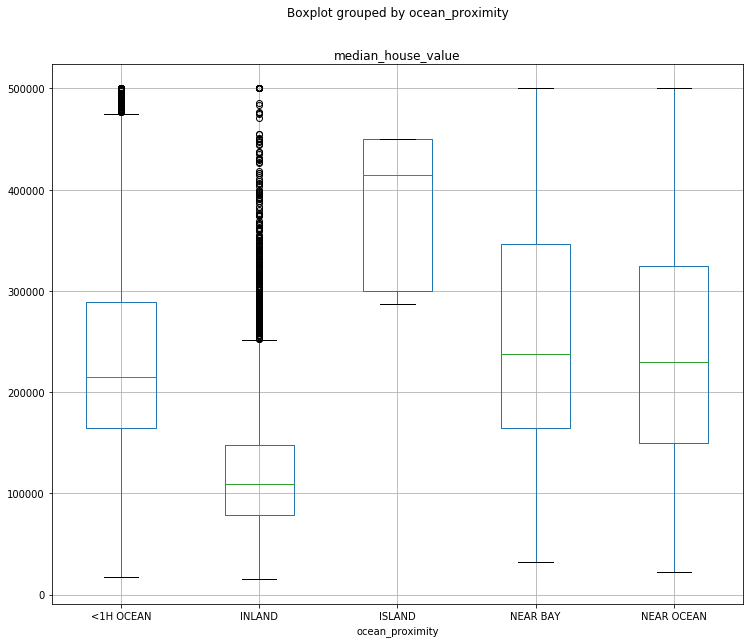

In [20]:
# Build box plots of categorical feature to evalutae its effect on house values
box_plot = df.boxplot(column='median_house_value',by='ocean_proximity',figsize=(12,10))

## Part 3 : Model Selection & Evaluation

In [21]:
# Seprate training data and labels
X_train = train.drop('median_house_value',axis=1)
y_train = train['median_house_value']

In [22]:
# Building transformer to create new features on dataset
class CombineAttributes(BaseEstimator,TransformerMixin):
    def __init__(self,ttl_room_idx=3,ttl_bed_idx=4,pop_idx=5,hh_idx=6):
        self.ttl_room_idx = ttl_room_idx
        self.ttl_bed_idx = ttl_bed_idx
        self.pop_idx = pop_idx
        self.hh_idx = hh_idx
    def fit(self,X, y=None):
        return self
    def transform(self,X,y=None):
        rooms_per_household = X[:,self.ttl_room_idx]/X[:,self.hh_idx]
        bedrooms_per_room = X[:,self.ttl_bed_idx]/X[:,self.ttl_room_idx]
        population_per_household = X[:,self.pop_idx]/X[:,self.hh_idx]
        return np.c_[X,rooms_per_household,bedrooms_per_room,population_per_household]

In [23]:
# Build the pipeline to perform all major transformation fiited on training data,
#this will help us apply consistent transformations to test datasets and any new dataset we get for scoring.
pipe_num = Pipeline([('imputer',SimpleImputer(strategy='median')),('attr_com',CombineAttributes()),
                     ('scaler',StandardScaler())])
num_attr = list(X_train.drop('ocean_proximity',axis=1).columns)
full_pipeline = ColumnTransformer([('num_pipe',pipe_num,num_attr),
                                   ('encoder',OneHotEncoder(),['ocean_proximity'])])

In [24]:
# Transform training dataset using the pipeine
X_train = full_pipeline.fit_transform(X_train)

In [25]:
# Build a function to train any given model, and give results, this will save a lot of time
def single_model_trainer(model,X,y,validation_set=True):
    if validation_set == True:
        train_X,test_X,train_y,test_y = train_test_split(X,y,random_state=42)
        model.fit(train_X,train_y)
        y_pred = model.predict(train_X)
        mse = mean_squared_error(train_y,y_pred)
        train_rmse = np.sqrt(mse)
        y_pred = model.predict(test_X)
        mse = mean_squared_error(test_y,y_pred)
        test_rmse = np.sqrt(mse)
        return (model,train_rmse,test_rmse)
    else:
        model.fit(X,y)
        y_pred = model.predict(X)
        mse = mean_squared_error(y,y_pred)
        rmse = np.sqrt(mse)
        return (model,rmse)

In [26]:
# Training Linear Regression Model
model,train_rmse,test_rmse = single_model_trainer(LinearRegression(),X_train,y_train)
print(f'Training Error : {train_rmse}')
print(f'Validation Error : {test_rmse}')

Training Error : 67580.86985178602
Validation Error : 69801.36310319843


In [27]:
# Training Decision Tree Model
model,train_rmse,test_rmse = single_model_trainer(DecisionTreeRegressor(),X_train,y_train)
print(f'Training Error : {train_rmse}')
print(f'Validation Error : {test_rmse}')

Training Error : 0.0
Validation Error : 75546.01445729953


In [28]:
# Training Random Forest Model
model,train_rmse,test_rmse = single_model_trainer(RandomForestRegressor(n_estimators=100),X_train,y_train)
print(f'Training Error : {train_rmse}')
print(f'Validation Error : {test_rmse}')

Training Error : 18805.073191921518
Validation Error : 52073.5895452804


In [29]:
# Training Gradient Boosting Model
model,train_rmse,test_rmse = single_model_trainer(GradientBoostingRegressor(n_estimators=100),X_train,y_train)
print(f'Training Error : {train_rmse}')
print(f'Validation Error : {test_rmse}')

Training Error : 50263.422963490135
Validation Error : 53825.494593416115


In [30]:
# training Support Vector Model
model,train_rmse,test_rmse = single_model_trainer(SVR(gamma='scale'),X_train,y_train)
print(f'Training Error : {train_rmse}')
print(f'Validation Error : {test_rmse}')

Training Error : 117589.27303238644
Validation Error : 119488.22918554992


In [31]:
# Training Model using KFold Cross Validation approch
models = {'LinearRegression':LinearRegression(),'DecisionTreeRegressor':DecisionTreeRegressor(),
          'RandomForestRegressor':RandomForestRegressor(n_estimators=100),'GradientBoostingRegressor':
          GradientBoostingRegressor(n_estimators=100),'SVR':SVR(gamma='scale')}
results = {}
for name,model in models.items():
    cv = KFold(n_splits=10, shuffle=False, random_state=42)
    scores = cross_val_score(model,X_train,y_train,cv=cv,scoring='neg_mean_squared_error')
    print(f'Cross Validation Completed for {name}')
    rmse_scores = np.sqrt(-scores)
    results[name] = rmse_scores
results_df = pd.DataFrame.from_dict(results)

Cross Validation Completed for LinearRegression
Cross Validation Completed for DecisionTreeRegressor
Cross Validation Completed for RandomForestRegressor
Cross Validation Completed for GradientBoostingRegressor
Cross Validation Completed for SVR


In [33]:
results_df

,LinearRegression,DecisionTreeRegressor,RandomForestRegressor,GradientBoostingRegressor,SVR
0,72998.914985,74287.241196,52264.798465,55413.558124,117520.605098
1,69538.278216,71638.732111,51263.970238,54691.661452,124207.931650
2,69092.534890,73549.989652,50899.927176,54491.449402,113651.965396
3,65714.818343,68734.898216,46533.561304,50365.333075,116244.091460
4,68706.192038,75378.361105,50966.885741,53598.092281,118608.895333
5,67701.576075,72993.568121,50087.347825,53265.832632,117498.757411
6,68558.778277,71457.088176,52100.650602,53944.889679,119449.045489
7,65238.713609,71453.810838,48306.625498,50549.464741,113399.133468
8,66544.369054,68781.111262,49035.058755,50810.212517,121678.138848
9,68960.691438,69937.381237,50695.762056,54353.481568,118928.058878


In [34]:
results_df.describe()

,LinearRegression,DecisionTreeRegressor,RandomForestRegressor,GradientBoostingRegressor,SVR
count,10.000000,10.000000,10.000000,10.000000,10.000000
mean,68305.486692,71821.218191,50215.458766,53148.397547,118118.662303
std,2221.221051,2253.760637,1786.577065,1873.382461,3314.878063
min,65238.713609,68734.898216,46533.561304,50365.333075,113399.133468
25%,66833.670809,70316.488637,49298.131022,51424.117546,116557.757948
50%,68632.485158,71547.910143,50797.844616,53771.490980,118064.750216
75%,69059.574027,73410.884269,51189.699114,54456.957444,119318.798837
max,72998.914985,75378.361105,52264.798465,55413.558124,124207.931650


## Part 4 : Final Model Development & Hyperparameter Tuning

In [38]:
# Train Random Forest Model using Grid Search to find best hyperparameters
forest_reg = RandomForestRegressor()
param_grid = {'bootstrap':[False],'n_estimators':(100,150),'max_depth':(10,15,None),'min_samples_split':(2,5),
          'max_features':(6,8,10,'auto'),'random_state':[42]}
grid_search_results = GridSearchCV(forest_reg,param_grid,scoring='neg_mean_squared_error',cv=5,return_train_score=True,
                                   n_jobs=5,verbose=1)

In [39]:
# Run the Grid Search
grid_search_results.fit(X_train,y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  2.6min
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed: 20.1min
[Parallel(n_jobs=5)]: Done 240 out of 240 | elapsed: 29.2min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=5,
       param_grid={'bootstrap': [False], 'n_estimators': (100, 150), 'max_depth': (10, 15, None), 'min_samples_split': (2, 5), 'max_features': (6, 8, 10, 'auto'), 'random_state': [42]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=1)

In [40]:
# Print Results of Grid Search
cv_res = grid_search_results.cv_results_
for score,params in zip(cv_res['mean_test_score'],cv_res['params']):
    print('-'*100)
    print(f'{np.sqrt(-score)}\n{params}')
    print(''*100)

----------------------------------------------------------------------------------------------------
52026.320369708854
{'bootstrap': False, 'max_depth': 10, 'max_features': 6, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 42}

----------------------------------------------------------------------------------------------------
52030.77414421539
{'bootstrap': False, 'max_depth': 10, 'max_features': 6, 'min_samples_split': 2, 'n_estimators': 150, 'random_state': 42}

----------------------------------------------------------------------------------------------------
52073.874971705336
{'bootstrap': False, 'max_depth': 10, 'max_features': 6, 'min_samples_split': 5, 'n_estimators': 100, 'random_state': 42}

----------------------------------------------------------------------------------------------------
52121.937976547946
{'bootstrap': False, 'max_depth': 10, 'max_features': 6, 'min_samples_split': 5, 'n_estimators': 150, 'random_state': 42}

-----------------------------

In [46]:
#  Select the best performing model to final training
reg_forest = grid_search_results.best_estimator_
reg_forest

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=None, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [47]:
# Training Final model on full dataset
model,rmse = single_model_trainer(reg_forest,X_train,y_train,validation_set=False)
print(f'Final Model Training Error : {rmse}')

Final Model Training Error : 0.0


In [48]:
# Transform Tests Data Set for final evaluation
X_test = test.drop('median_house_value',axis=1)
y_test = test['median_house_value']
X_test = full_pipeline.transform(X_test)

In [49]:
# Evaluate the model on test set
y_pred = reg_forest.predict(X_test)
mse = mean_squared_error(y_test,y_pred)
rmse = np.sqrt(mse)
print(f'Final Model Testing Error : {rmse}')

Final Model Testing Error : 46617.132835005184


In [53]:
# Get the 95% confidence interval of the testing set error
confidence = 0.95
squared_error = (y_pred - y_test)**2
CI = np.sqrt(stats.t.interval(confidence,len(squared_error)-1,loc=squared_error.mean(),scale=stats.sem(squared_error)))
print(f'Testing Error 95% Confidence Interval is Between {CI[0]} - {CI[1]}')

Testing Error 95% Confidence Interval is Between 44576.980670838464 - 48571.66809761363


## Part 7 : Result Visualization and Conclusion

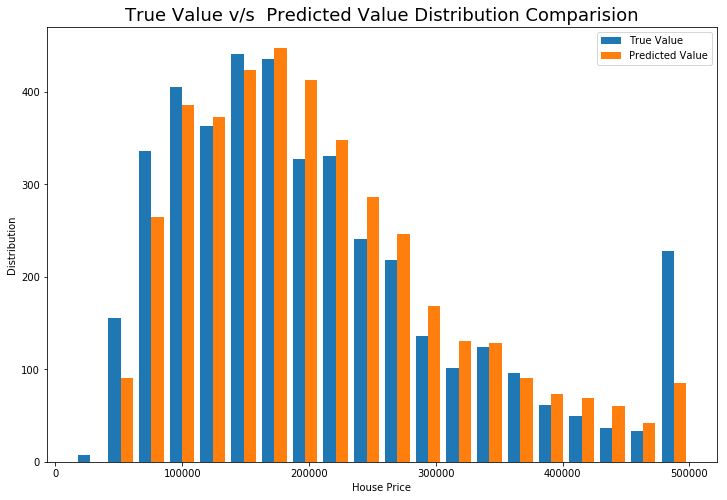

In [103]:
plt.figure(figsize=(12,8))
plot = plt.hist([test['median_house_value'],y_pred],bins=20,label=['True Value','Predicted Value'])
plt.xlabel('House Price')
plt.ylabel('Distribution')
plot = plt.legend()
plot = plt.title('True Value v/s  Predicted Value Distribution Comparision',fontsize=18)

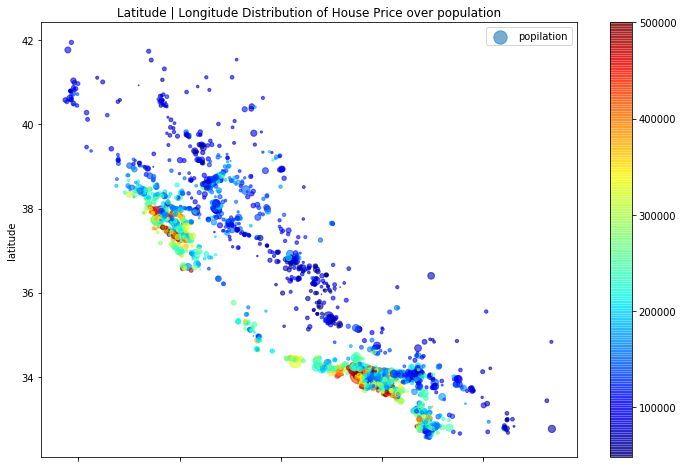

In [107]:
# Plot the Latitude & Longitude to visualize the distribution of population and median house value
sct_plot = test.plot(kind='scatter',x='longitude',y='latitude',alpha=0.6,s=df['population']/100,
                   label='popilation',c=y_pred,cmap=plt.get_cmap('jet'),figsize=(12,8),colorbar=True)
sct_plot = plt.legend()
sct_plot = plt.title('Latitude | Longitude Distribution of House Price over population')

### Habbit of learning is one of the most useful things to have in these uncertain times

I really enjoyed doing this notebook, and I hope you would have enjoyed reading it.

Please feel free to leave a comment or suggestions of improvement.

As I go throught this book, I would continue adding more notebooks if i get time.